# **Supervised Learning-Final Project** - Alice Menna (888364) and Federica Tonoli (898661)

#Libraries and Dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import pandas as pd
import numpy as np
import cv2
import os
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import warnings

# Disable warnings for cleaner output
warnings.filterwarnings('ignore')

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/SupervisedLearning/train.zip"
!unzip "/content/drive/MyDrive/SupervisedLearning/val.zip"
!unzip "/content/drive/MyDrive/SupervisedLearning/test.zip"

Output streaming troncato alle ultime 5000 righe.
  inflating: val/val_119357.jpg      
  inflating: val/val_119358.jpg      
  inflating: val/val_119359.jpg      
  inflating: val/val_119360.jpg      
  inflating: val/val_119842.jpg      
  inflating: val/val_119843.jpg      
  inflating: val/val_119844.jpg      
  inflating: val/val_119845.jpg      
  inflating: val/val_119846.jpg      
  inflating: val/val_119847.jpg      
  inflating: val/val_119848.jpg      
  inflating: val/val_119849.jpg      
  inflating: val/val_119850.jpg      
  inflating: val/val_119851.jpg      
  inflating: val/val_119852.jpg      
  inflating: val/val_119853.jpg      
  inflating: val/val_119854.jpg      
  inflating: val/val_119855.jpg      
  inflating: val/val_119856.jpg      
Archive:  /content/drive/MyDrive/SupervisedLearning/test.zip
   creating: test/
  inflating: test/test_000000.jpg    
  inflating: test/test_000001.jpg    
  inflating: test/test_000002.jpg    
  inflating: test/test_000003.jpg 

#Configuration and Constants

In [ ]:
# Dataset paths
imgTrainDir = "/content/train"
imgValDir = "/content/val"
imgTestDir = "/content/test"
annotTrainDir = "/content/drive/MyDrive/SupervisedLearning/train_info.csv"
annotValDir = "/content/drive/MyDrive/SupervisedLearning/val_info.csv"
annotTestDir = "/content/drive/MyDrive/SupervisedLearning/test_info.csv"
annotClassDir = "/content/drive/MyDrive/SupervisedLearning/class_list.txt"

In [ ]:
# Training parameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 160
BATCH_SIZE = 64
NUM_EPOCHS = 70
NUM_WORKERS = 2
LEARNING_RATE = 0.001

print(f"Using device: {DEVICE}")

Using device: cuda


#Load and Analyze Dataset

In [ ]:
# Load class names
with open(annotClassDir, 'r') as f:
    classNames = [line.strip() for line in f.readlines()]

NUM_CLASSES = len(classNames)
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 251


In [ ]:
# Load annotations
trainDf = pd.read_csv(annotTrainDir)
valDf = pd.read_csv(annotValDir)
testDf = pd.read_csv(annotTestDir)

In [ ]:
# Create class distribution analysis table
analysisData = []
for i, className in enumerate(classNames):
    trainCount = len(trainDf[trainDf['class'] == i])
    valCount = len(valDf[valDf['class'] == i])
    testCount = len(testDf[testDf['class'] == i])

    analysisData.append({
        'Class': i,
        'Name': className,
        'Train': trainCount,
        'Val': valCount,
        'Test': testCount
    })

analysisTable = pd.DataFrame(analysisData)

# Print dataset statistics
print("\nClass Distribution Analysis:")
print(f"  - Total train samples: {analysisTable['Train'].sum()}")
print(f"  - Total val samples: {analysisTable['Val'].sum()}")
print(f"  - Total test samples: {analysisTable['Test'].sum()}")
print(f"  - Average samples per class - Train: {analysisTable['Train'].mean():.1f}, Val: {analysisTable['Val'].mean():.1f}, Test: {analysisTable['Test'].mean():.1f}")
print(analysisTable.to_string(index=False))


Class Distribution Analysis:
  - Total train samples: 21269
  - Total val samples: 3765
  - Total test samples: 4979
  - Average samples per class - Train: 84.7, Val: 15.0, Test: 19.8
 Class                              Name  Train  Val  Test
     0                         0 macaron     85   15    20
     1                         1 beignet     85   15    20
     2                         2 cruller     85   15    20
     3                     3 cockle_food     85   15    20
     4                          4 samosa     85   15    20
     5                        5 tiramisu     85   15    20
     6                         6 tostada     85   15    20
     7                        7 moussaka     85   15    20
     8                        8 dumpling     85   15    20
     9                         9 sashimi     85   15    20
    10                          10 knish     85   15    20
    11                      11 croquette     85   15    20
    12                       12 couscous     85 

#SUPERVISED LEARNING

##Custom Dataset Class

In [ ]:
class FoodDataset(Dataset):
    """Custom dataset class for food image classification"""

    # Initialize dataset
    def __init__(self, dataframe, imageDir, transform=None):
        self.dataframe = dataframe
        self.imageDir = imageDir
        self.transform = transform
        self.imagePathMap = {}
        self._buildImagePathMap()

    # Build mapping of image names to full paths
    def _buildImagePathMap(self):
        for root, dirs, files in os.walk(self.imageDir):
            for file in files:
                if file.lower().endswith('.jpg'):
                    self.imagePathMap[file] = os.path.join(root, file)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        imageName = row['file_name']
        label = row['class']

        # Fast path lookup
        imagePath = self.imagePathMap.get(imageName)
        if imagePath is None:
            raise FileNotFoundError(f"Image {imageName} not found")

        # Load and process image
        image = Image.open(imagePath).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

##Data Transformations

In [ ]:
# Data augmentation for training
trainTransforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Standard transforms for validation and test
valTestTransforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

##Create Datasets

In [ ]:
trainDataset = FoodDataset(trainDf, imgTrainDir, trainTransforms)
valDataset = FoodDataset(valDf, imgValDir, valTestTransforms)
testDataset = FoodDataset(testDf, imgTestDir, valTestTransforms)

print(f"Training samples: {len(trainDataset)}")
print(f"Validation samples: {len(valDataset)}")
print(f"Test samples: {len(testDataset)}")

Training samples: 21269
Validation samples: 3765
Test samples: 4979


##Balanced Sampler for Training

In [ ]:
def createBalancedSampler(dataset):
    """Create weighted sampler for balanced class sampling"""

    # Get all labels from dataset
    allLabels = []
    for i in range(len(dataset)):
        label = dataset.dataframe.iloc[i]['class']
        allLabels.append(label)

    allLabels = torch.tensor(allLabels)

    # Calculate class frequencies
    classFrequencies = torch.bincount(allLabels, minlength=NUM_CLASSES)

    # Calculate inverse weights
    classWeights = 1.0 / (classFrequencies.float() + 1e-6)
    classWeights = classWeights / classWeights.sum() * len(classWeights)

    # Assign weights to samples
    sampleWeights = torch.zeros(len(allLabels))
    for i, label in enumerate(allLabels):
        sampleWeights[i] = classWeights[label]

    return WeightedRandomSampler(
        weights=sampleWeights,
        num_samples=len(sampleWeights),
        replacement=True
    )

In [ ]:
# Create balanced samplers
balancedSamplerTrain = createBalancedSampler(trainDataset)
balancedSamplerVal = createBalancedSampler(valDataset)

##Data Loaders

In [ ]:
trainLoader = DataLoader(
    trainDataset,
    batch_size=BATCH_SIZE,
    sampler=balancedSamplerTrain,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True,
    drop_last=True
)

valLoader = DataLoader(
    valDataset,
    batch_size=BATCH_SIZE,
    sampler=balancedSamplerVal,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True,
    drop_last=True
)

testLoader = DataLoader(
    testDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

print(f"Train batches: {len(trainLoader)}")
print(f"Val batches: {len(valLoader)}")
print(f"Test batches: {len(testLoader)}")

Train batches: 332
Val batches: 58
Test batches: 78


##Custom CNN Architecture

In [ ]:
class SupLearnCNN(nn.Module):
    """Custom CNN architecture for food classification"""

    def __init__(self, numClasses):
        super(SupLearnCNN, self).__init__()

        # Feature extraction layers
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # Block 3
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Block 4
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Block 5
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # Global Average Pooling
            nn.AdaptiveAvgPool2d((7, 7))
        )

        # Classifier with dropout
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, numClasses)
        )

        self._initializeWeights()

    def _initializeWeights(self):
        """Initialize weights using Xavier/He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# Create and setup model
model = SupLearnCNN(NUM_CLASSES).to(DEVICE)

# Compile model for faster execution (PyTorch 2.0+)
model = torch.compile(model)

totalParams = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model created with {totalParams:,} trainable parameters")
print(f"Parameter constraint satisfied: {totalParams < 5_000_000}")

Model created with 4,110,203 trainable parameters
Parameter constraint satisfied: True


##Training Function

In [ ]:
def trainModel(model, trainLoader, valLoader, criterion, optimizer, scheduler, numEpochs):
    """Train the model with validation monitoring, early stopping, and gradient clipping"""

    # Initialize mixed precision scaler
    if DEVICE == "cuda":
        scaler = torch.amp.GradScaler('cuda')
    else:
        scaler = None

    trainLosses = []
    valLosses = []
    trainAccuracies = []
    valAccuracies = []
    bestValAcc = 0.0
    patienceCounter = 0
    patience = 7

    for epoch in range(numEpochs):
        print(f"\nEpoch [{epoch+1}/{numEpochs}] - LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Training phase
        model.train()
        runningLoss = 0.0
        correctPreds = 0
        totalSamples = 0

        for images, labels in tqdm(trainLoader, desc="Training"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()

            # Forward pass with mixed precision
            if DEVICE == "cuda" and scaler is not None:
                with torch.amp.autocast('cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            # Update statistics
            runningLoss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            totalSamples += labels.size(0)
            correctPreds += (predicted == labels).sum().item()

        epochTrainLoss = runningLoss / len(trainLoader)
        epochTrainAcc = 100 * correctPreds / totalSamples

        # Validation phase
        model.eval()
        valRunningLoss = 0.0
        valCorrectPreds = 0
        valTotalSamples = 0

        with torch.no_grad():
            for images, labels in tqdm(valLoader, desc="Validation"):
                images, labels = images.to(DEVICE), labels.to(DEVICE)

                if DEVICE == "cuda" and scaler is not None:
                    with torch.amp.autocast('cuda'):
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                else:
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                valRunningLoss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                valTotalSamples += labels.size(0)
                valCorrectPreds += (predicted == labels).sum().item()

        epochValLoss = valRunningLoss / len(valLoader)
        epochValAcc = 100 * valCorrectPreds / valTotalSamples

        # Update learning rate
        scheduler.step(epochValLoss)

        # Store metrics
        trainLosses.append(epochTrainLoss)
        valLosses.append(epochValLoss)
        trainAccuracies.append(epochTrainAcc)
        valAccuracies.append(epochValAcc)

        # Print epoch results
        print(f"  - Train Loss: {epochTrainLoss:.4f}, Train Acc: {epochTrainAcc:.2f}%")
        print(f"  - Val Loss: {epochValLoss:.4f}, Val Acc: {epochValAcc:.2f}%")

        # Early stopping check
        if epochValAcc > bestValAcc:
            bestValAcc = epochValAcc
            patienceCounter = 0
        else:
            patienceCounter += 1
            if patienceCounter >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement")
                break

    return trainLosses, valLosses, trainAccuracies, valAccuracies

In [ ]:
# Setup Training Components
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [ ]:
# Train the model
trainLosses, valLosses, trainAccs, valAccs = trainModel(
    model, trainLoader, valLoader, criterion, optimizer, scheduler, NUM_EPOCHS
)


Epoch [1/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:10<00:00,  5.30it/s]


  - Train Loss: 5.2945, Train Acc: 2.17%
  - Val Loss: 5.2646, Val Acc: 2.29%

Epoch [2/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.36it/s]


  - Train Loss: 5.0208, Train Acc: 4.28%
  - Val Loss: 5.0283, Val Acc: 4.12%

Epoch [3/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.61it/s]


  - Train Loss: 4.8635, Train Acc: 6.02%
  - Val Loss: 5.0924, Val Acc: 4.31%

Epoch [4/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.08it/s]


  - Train Loss: 4.7411, Train Acc: 7.77%
  - Val Loss: 4.9947, Val Acc: 5.50%

Epoch [5/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.24it/s]


  - Train Loss: 4.6293, Train Acc: 9.11%
  - Val Loss: 4.8164, Val Acc: 8.03%

Epoch [6/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.51it/s]


  - Train Loss: 4.5243, Train Acc: 11.06%
  - Val Loss: 4.7114, Val Acc: 9.43%

Epoch [7/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.55it/s]


  - Train Loss: 4.4579, Train Acc: 12.03%
  - Val Loss: 4.7166, Val Acc: 8.92%

Epoch [8/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.43it/s]


  - Train Loss: 4.3719, Train Acc: 13.25%
  - Val Loss: 4.6571, Val Acc: 10.34%

Epoch [9/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.39it/s]


  - Train Loss: 4.3038, Train Acc: 14.44%
  - Val Loss: 4.6518, Val Acc: 10.53%

Epoch [10/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.43it/s]


  - Train Loss: 4.2321, Train Acc: 15.68%
  - Val Loss: 4.5836, Val Acc: 11.69%

Epoch [11/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.27it/s]


  - Train Loss: 4.1661, Train Acc: 16.86%
  - Val Loss: 4.6053, Val Acc: 11.96%

Epoch [12/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.51it/s]


  - Train Loss: 4.0969, Train Acc: 18.11%
  - Val Loss: 4.5568, Val Acc: 12.39%

Epoch [13/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.40it/s]


  - Train Loss: 4.0381, Train Acc: 19.18%
  - Val Loss: 4.5620, Val Acc: 12.42%

Epoch [14/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.50it/s]


  - Train Loss: 3.9856, Train Acc: 20.42%
  - Val Loss: 4.5576, Val Acc: 13.31%

Epoch [15/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.66it/s]


  - Train Loss: 3.9377, Train Acc: 21.01%
  - Val Loss: 4.5435, Val Acc: 12.98%

Epoch [16/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.25it/s]


  - Train Loss: 3.8786, Train Acc: 22.48%
  - Val Loss: 4.4851, Val Acc: 13.95%

Epoch [17/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.57it/s]


  - Train Loss: 3.8034, Train Acc: 23.75%
  - Val Loss: 4.5020, Val Acc: 14.01%

Epoch [18/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.63it/s]


  - Train Loss: 3.7576, Train Acc: 24.39%
  - Val Loss: 4.4688, Val Acc: 14.47%

Epoch [19/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.16it/s]


  - Train Loss: 3.7151, Train Acc: 25.06%
  - Val Loss: 4.5425, Val Acc: 13.55%

Epoch [20/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.24it/s]


  - Train Loss: 3.6796, Train Acc: 26.03%
  - Val Loss: 4.5288, Val Acc: 14.52%

Epoch [21/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.29it/s]


  - Train Loss: 3.6249, Train Acc: 27.14%
  - Val Loss: 4.5267, Val Acc: 14.09%

Epoch [22/70] - LR: 0.001000


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.56it/s]


  - Train Loss: 3.5934, Train Acc: 27.71%
  - Val Loss: 4.5227, Val Acc: 14.39%

Epoch [23/70] - LR: 0.000500


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.71it/s]


  - Train Loss: 3.4519, Train Acc: 30.81%
  - Val Loss: 4.3852, Val Acc: 16.46%

Epoch [24/70] - LR: 0.000500


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.71it/s]


  - Train Loss: 3.4067, Train Acc: 32.22%
  - Val Loss: 4.3933, Val Acc: 16.06%

Epoch [25/70] - LR: 0.000500


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.06it/s]


  - Train Loss: 3.3610, Train Acc: 33.51%
  - Val Loss: 4.3858, Val Acc: 17.19%

Epoch [26/70] - LR: 0.000500


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.56it/s]


  - Train Loss: 3.3232, Train Acc: 34.30%
  - Val Loss: 4.4236, Val Acc: 16.19%

Epoch [27/70] - LR: 0.000500


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.63it/s]


  - Train Loss: 3.2935, Train Acc: 34.50%
  - Val Loss: 4.4359, Val Acc: 16.92%

Epoch [28/70] - LR: 0.000250


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.21it/s]


  - Train Loss: 3.2280, Train Acc: 36.34%
  - Val Loss: 4.4414, Val Acc: 15.36%

Epoch [29/70] - LR: 0.000250


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.42it/s]


  - Train Loss: 3.1876, Train Acc: 37.42%
  - Val Loss: 4.3677, Val Acc: 18.10%

Epoch [30/70] - LR: 0.000250


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.43it/s]


  - Train Loss: 3.2061, Train Acc: 36.70%
  - Val Loss: 4.3473, Val Acc: 17.59%

Epoch [31/70] - LR: 0.000250


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.49it/s]


  - Train Loss: 3.1484, Train Acc: 38.67%
  - Val Loss: 4.3709, Val Acc: 17.94%

Epoch [32/70] - LR: 0.000250


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.54it/s]


  - Train Loss: 3.1256, Train Acc: 38.32%
  - Val Loss: 4.4003, Val Acc: 18.16%

Epoch [33/70] - LR: 0.000250


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.54it/s]


  - Train Loss: 3.1146, Train Acc: 39.46%
  - Val Loss: 4.3803, Val Acc: 17.97%

Epoch [34/70] - LR: 0.000250


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.73it/s]


  - Train Loss: 3.1097, Train Acc: 39.14%
  - Val Loss: 4.4378, Val Acc: 17.43%

Epoch [35/70] - LR: 0.000125


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.60it/s]


  - Train Loss: 3.0839, Train Acc: 39.66%
  - Val Loss: 4.4150, Val Acc: 16.89%

Epoch [36/70] - LR: 0.000125


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.21it/s]


  - Train Loss: 3.0442, Train Acc: 40.68%
  - Val Loss: 4.3968, Val Acc: 18.32%

Epoch [37/70] - LR: 0.000125


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.49it/s]


  - Train Loss: 3.0495, Train Acc: 41.11%
  - Val Loss: 4.4080, Val Acc: 17.27%

Epoch [38/70] - LR: 0.000125


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.60it/s]


  - Train Loss: 3.0470, Train Acc: 41.15%
  - Val Loss: 4.3849, Val Acc: 19.07%

Epoch [39/70] - LR: 0.000063


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.45it/s]


  - Train Loss: 3.0213, Train Acc: 41.16%
  - Val Loss: 4.4140, Val Acc: 17.94%

Epoch [40/70] - LR: 0.000063


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.31it/s]


  - Train Loss: 3.0112, Train Acc: 41.35%
  - Val Loss: 4.4413, Val Acc: 17.30%

Epoch [41/70] - LR: 0.000063


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.61it/s]


  - Train Loss: 3.0048, Train Acc: 41.68%
  - Val Loss: 4.3615, Val Acc: 18.10%

Epoch [42/70] - LR: 0.000063


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.66it/s]


  - Train Loss: 3.0064, Train Acc: 42.07%
  - Val Loss: 4.3792, Val Acc: 18.53%

Epoch [43/70] - LR: 0.000031


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.51it/s]


  - Train Loss: 2.9829, Train Acc: 42.49%
  - Val Loss: 4.3344, Val Acc: 18.72%

Epoch [44/70] - LR: 0.000031


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.11it/s]


  - Train Loss: 2.9876, Train Acc: 42.64%
  - Val Loss: 4.4389, Val Acc: 17.00%

Epoch [45/70] - LR: 0.000031


Validation: 100%|██████████| 58/58 [00:04<00:00, 12.39it/s]

  - Train Loss: 2.9873, Train Acc: 42.00%
  - Val Loss: 4.3364, Val Acc: 18.18%
Early stopping triggered after 7 epochs without improvement


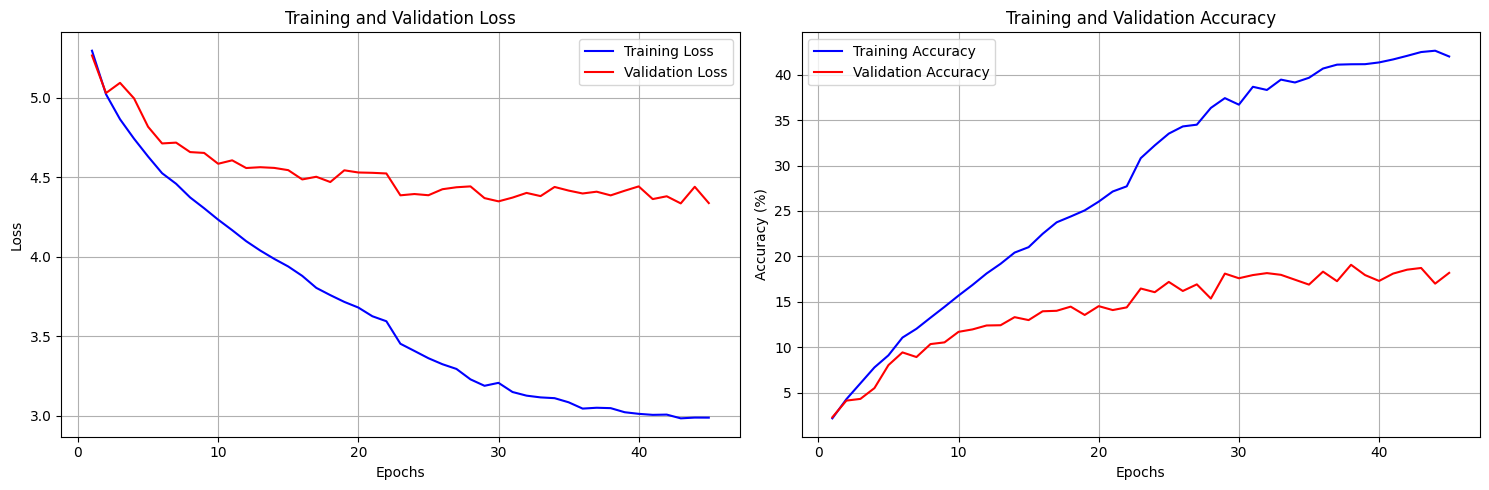

In [ ]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
epochs = range(1, len(trainLosses) + 1)
ax1.plot(epochs, trainLosses, 'b-', label='Training Loss')
ax1.plot(epochs, valLosses, 'r-', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(epochs, trainAccs, 'b-', label='Training Accuracy')
ax2.plot(epochs, valAccs, 'r-', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

##Test Model Performance

In [ ]:
def testModel(model, testLoader):
    """Evaluate model on test set"""

    model.eval()
    allPredictions = []
    allLabels = []
    testLoss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(testLoader, desc="Testing"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)
            testLoss += loss.item()

            _, predicted = torch.max(outputs, 1)

            allPredictions.extend(predicted.cpu().numpy())
            allLabels.extend(labels.cpu().numpy())

    testLoss /= len(testLoader)
    return np.array(allPredictions), np.array(allLabels), testLoss

In [ ]:
# Test the supervised model
testPredictions, testLabels, testLoss = testModel(model, testLoader)

Testing: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


In [ ]:
# Calculate metrics
testAccuracy = accuracy_score(testLabels, testPredictions)
testPrecision = precision_score(testLabels, testPredictions, average='weighted', zero_division=0)
testRecall = recall_score(testLabels, testPredictions, average='weighted', zero_division=0)
testF1 = f1_score(testLabels, testPredictions, average='weighted', zero_division=0)

print(f"  - Test Loss: {testLoss:.4f}")
print(f"  - Test Accuracy: {testAccuracy:.4f} ({testAccuracy*100:.2f}%)")
print(f"  - Test Precision: {testPrecision:.4f}")
print(f"  - Test Recall: {testRecall:.4f}")
print(f"  - Test F1-Score: {testF1:.4f}")

  - Test Loss: 4.1179
  - Test Accuracy: 0.2049 (20.49%)
  - Test Precision: 0.1947
  - Test Recall: 0.2049
  - Test F1-Score: 0.1929


In [ ]:
# Detailed classification report
print(classification_report(testLabels, testPredictions,
                          target_names=[f"Class_{i}" for i in range(NUM_CLASSES)],
                          digits=4, zero_division=0))

              precision    recall  f1-score   support

     Class_0     0.3333    0.1000    0.1538        20
     Class_1     0.3600    0.4500    0.4000        20
     Class_2     0.1429    0.0500    0.0741        20
     Class_3     0.1364    0.1500    0.1429        20
     Class_4     0.1515    0.2500    0.1887        20
     Class_5     0.2609    0.3000    0.2791        20
     Class_6     0.2000    0.2000    0.2000        20
     Class_7     0.2222    0.2000    0.2105        20
     Class_8     0.2727    0.1500    0.1935        20
     Class_9     0.3889    0.3500    0.3684        20
    Class_10     0.1429    0.1000    0.1176        20
    Class_11     0.2500    0.2500    0.2500        20
    Class_12     0.1429    0.0500    0.0741        20
    Class_13     0.2174    0.2500    0.2326        20
    Class_14     0.0000    0.0000    0.0000        20
    Class_15     0.5882    0.5000    0.5405        20
    Class_16     0.0833    0.1000    0.0909        20
    Class_17     0.0667    

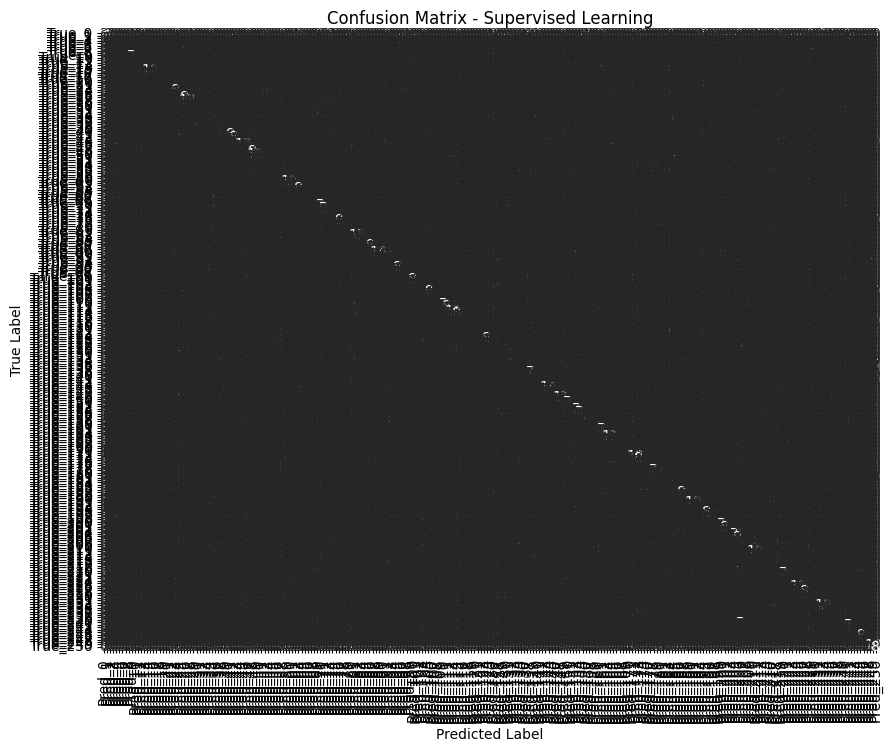

In [ ]:
# Generate and plot confusion matrix
confMatrix = confusion_matrix(testLabels, testPredictions)

plt.figure(figsize=(10, 8))
sns.heatmap(confMatrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f"Pred_{i}" for i in range(NUM_CLASSES)],
            yticklabels=[f"True_{i}" for i in range(NUM_CLASSES)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Supervised Learning')
plt.show()

In [ ]:
# Save model
torch.save(model.state_dict(), 'best_model.pth')

#SELF-SUPERVISED LEARNING

##Dataset Class

In [ ]:
class SimCLRDataset(Dataset):
    """Dataset class for SimCLR self-supervised learning"""

    def __init__(self, imageDir, transform):
        # Build list of all image paths
        self.imagePaths = []
        for fileName in os.listdir(imageDir):
            if fileName.lower().endswith('.jpg'):
                self.imagePaths.append(os.path.join(imageDir, fileName))

        self.transform = transform
        print(f"SSL Dataset created with {len(self.imagePaths)} images")

    def __len__(self):
        return len(self.imagePaths)

    def __getitem__(self, idx):
        # Load image and create two augmented views
        image = Image.open(self.imagePaths[idx]).convert('RGB')

        # Return two different augmented versions of the same image
        view1 = self.transform(image)
        view2 = self.transform(image)

        return view1, view2

##Data Transformations

In [ ]:
sslTransforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.ColorJitter(
            brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

##Create Dataset

In [ ]:
# Create SSL dataset using training images
sslDataset = SimCLRDataset(imgTrainDir, sslTransforms)

# Create datasets for feature extraction
trainDatasetForFeatures = FoodDataset(trainDf, imgTrainDir, valTestTransforms)  # NO augmentation
testDatasetForFeatures = FoodDataset(testDf, imgTestDir, valTestTransforms)

SSL Dataset created with 21269 images


##Data Loader

In [ ]:
# Create SSL data loader
sslLoader = DataLoader(
    sslDataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True,
    drop_last=True
)

print(f"SSL batches: {len(sslLoader)}")

# Create data loaders for features extraction
trainLoaderForFeatures = DataLoader(
    trainDatasetForFeatures,
    batch_size=BATCH_SIZE,
    shuffle=False,  # NO shuffle per feature extraction
    num_workers=NUM_WORKERS,
    pin_memory=True
)

testLoaderForFeatures = DataLoader(
    testDatasetForFeatures,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
print(f"Train batches: {len(trainLoaderForFeatures)}")
print(f"Test batches: {len(testLoaderForFeatures)}")

SSL batches: 332
Train batches: 333
Test batches: 78


##CNN Architecture

In [ ]:
# SSL Model with encoder and projection head
class SSLModel(nn.Module):
    def __init__(self, featureExtractor):
        super().__init__()
        self.featureExtractor = featureExtractor
        self.projectionHead = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128)
        )

    def forward(self, x):
        # Extract features using CNN backbone
        x = self.featureExtractor(x)
        # Flatten features
        x = torch.flatten(x, 1)
        # Apply projection head
        x = self.projectionHead(x)
        return x

In [ ]:
# Create SSL model using CustomCNN feature extractor
sslEncoder = SupLearnCNN(numClasses=NUM_CLASSES).to(DEVICE)
featureExtractor = sslEncoder.features          # Output: (B, 64, 7, 7)
sslModel = SSLModel(featureExtractor).to(DEVICE)

# Calculate total parameters
sslTotalParams = sum(p.numel() for p in sslModel.parameters() if p.requires_grad)
print(f"SSL Model created with {sslTotalParams:,} trainable parameters")

SSL Model created with 1,914,112 trainable parameters


##SimCLR contrastive loss function

In [ ]:
class SimCLRLoss(nn.Module):
    """SimCLR contrastive loss with temperature scaling"""

    def __init__(self, temperature=0.5):
        super(SimCLRLoss, self).__init__()
        self.temperature = temperature

    def forward(self, zi, zj):
        """
        Compute SimCLR loss between two views
        zi, zj: [batchSize, projectionDim] - two views of the same images
        """
        batchSize = zi.size(0)

        # Normalize projections to unit sphere
        zi = F.normalize(zi, dim=1)
        zj = F.normalize(zj, dim=1)

        # Concatenate all projections
        allProjections = torch.cat([zi, zj], dim=0)  # Shape: [2*batchSize, projectionDim]

        # Compute cosine similarity matrix
        similarityMatrix = torch.matmul(allProjections, allProjections.T) / self.temperature

        # Create positive pair labels
        # For batch of size N: samples [0,N-1] pair with [N,2N-1]
        positiveLabels = torch.arange(batchSize).to(zi.device)
        allLabels = torch.cat([positiveLabels + batchSize, positiveLabels], dim=0)

        # Mask out self-similarity (diagonal elements)
        selfMask = torch.eye(2 * batchSize, dtype=torch.bool).to(zi.device)
        similarityMatrix.masked_fill_(selfMask, -1e9)

        # Compute cross-entropy loss
        loss = F.cross_entropy(similarityMatrix, allLabels)

        return loss

##Training

In [ ]:
# Initialize SSL training components
sslCriterion = SimCLRLoss(temperature=0.5)
sslOptimizer = optim.AdamW(sslModel.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
sslScheduler = optim.lr_scheduler.ReduceLROnPlateau(sslOptimizer, mode='min', factor=0.7, patience=5)

In [ ]:
# SSL Training Loop
sslModel.train()
sslLosses = []

for epoch in range(NUM_EPOCHS):
    print(f"\nSSL Epoch [{epoch+1}/{NUM_EPOCHS}] - LR: {sslOptimizer.param_groups[0]['lr']:.6f}")

    runningLoss = 0.0
    numBatches = 0

    # Training with progress bar
    for view1, view2 in tqdm(sslLoader, desc="SSL Training"):
        view1, view2 = view1.to(DEVICE), view2.to(DEVICE)

        # Zero gradients
        sslOptimizer.zero_grad()

        # Forward pass through both views
        projections1 = sslModel(view1)
        projections2 = sslModel(view2)

        # Compute contrastive loss
        loss = sslCriterion(projections1, projections2)

        # Backward pass
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(sslModel.parameters(), max_norm=1.0)

        # Update parameters
        sslOptimizer.step()

        # Update statistics
        runningLoss += loss.item()
        numBatches += 1

    # Calculate epoch metrics
    epochLoss = runningLoss / numBatches
    sslLosses.append(epochLoss)

    # Update learning rate
    sslScheduler.step(epochLoss)

    # Print epoch results
    print(f"  - SSL Loss: {epochLoss:.4f}")


SSL Epoch [1/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.77it/s]


  - SSL Loss: 3.4663

SSL Epoch [2/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.78it/s]


  - SSL Loss: 3.3206

SSL Epoch [3/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:57<00:00,  2.82it/s]


  - SSL Loss: 3.2636

SSL Epoch [4/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.2324

SSL Epoch [5/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.78it/s]


  - SSL Loss: 3.2089

SSL Epoch [6/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.79it/s]


  - SSL Loss: 3.1905

SSL Epoch [7/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.77it/s]


  - SSL Loss: 3.1781

SSL Epoch [8/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.78it/s]


  - SSL Loss: 3.1670

SSL Epoch [9/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.78it/s]


  - SSL Loss: 3.1586

SSL Epoch [10/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.78it/s]


  - SSL Loss: 3.1525

SSL Epoch [11/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.1444

SSL Epoch [12/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.1409

SSL Epoch [13/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:57<00:00,  2.82it/s]


  - SSL Loss: 3.1348

SSL Epoch [14/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.1291

SSL Epoch [15/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.1276

SSL Epoch [16/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:57<00:00,  2.81it/s]


  - SSL Loss: 3.1217

SSL Epoch [17/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.80it/s]


  - SSL Loss: 3.1207

SSL Epoch [18/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.80it/s]


  - SSL Loss: 3.1158

SSL Epoch [19/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.78it/s]


  - SSL Loss: 3.1116

SSL Epoch [20/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.1116

SSL Epoch [21/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.1082

SSL Epoch [22/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.80it/s]


  - SSL Loss: 3.1053

SSL Epoch [23/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.77it/s]


  - SSL Loss: 3.1009

SSL Epoch [24/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.1008

SSL Epoch [25/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.80it/s]


  - SSL Loss: 3.0961

SSL Epoch [26/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.80it/s]


  - SSL Loss: 3.0966

SSL Epoch [27/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.0941

SSL Epoch [28/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.78it/s]


  - SSL Loss: 3.0914

SSL Epoch [29/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [02:01<00:00,  2.73it/s]


  - SSL Loss: 3.0926

SSL Epoch [30/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [02:02<00:00,  2.71it/s]


  - SSL Loss: 3.0910

SSL Epoch [31/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.79it/s]


  - SSL Loss: 3.0876

SSL Epoch [32/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:57<00:00,  2.82it/s]


  - SSL Loss: 3.0863

SSL Epoch [33/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.80it/s]


  - SSL Loss: 3.0841

SSL Epoch [34/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.0838

SSL Epoch [35/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.0834

SSL Epoch [36/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.78it/s]


  - SSL Loss: 3.0829

SSL Epoch [37/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.0796

SSL Epoch [38/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.77it/s]


  - SSL Loss: 3.0781

SSL Epoch [39/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.0784

SSL Epoch [40/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.78it/s]


  - SSL Loss: 3.0767

SSL Epoch [41/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.78it/s]


  - SSL Loss: 3.0767

SSL Epoch [42/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.79it/s]


  - SSL Loss: 3.0765

SSL Epoch [43/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:57<00:00,  2.82it/s]


  - SSL Loss: 3.0732

SSL Epoch [44/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.0738

SSL Epoch [45/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.0725

SSL Epoch [46/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.79it/s]


  - SSL Loss: 3.0719

SSL Epoch [47/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.78it/s]


  - SSL Loss: 3.0718

SSL Epoch [48/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.79it/s]


  - SSL Loss: 3.0708

SSL Epoch [49/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.0690

SSL Epoch [50/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.79it/s]


  - SSL Loss: 3.0666

SSL Epoch [51/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.80it/s]


  - SSL Loss: 3.0667

SSL Epoch [52/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.79it/s]


  - SSL Loss: 3.0658

SSL Epoch [53/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.0645

SSL Epoch [54/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.79it/s]


  - SSL Loss: 3.0641

SSL Epoch [55/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.77it/s]


  - SSL Loss: 3.0645

SSL Epoch [56/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:59<00:00,  2.77it/s]


  - SSL Loss: 3.0651

SSL Epoch [57/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [02:00<00:00,  2.76it/s]


  - SSL Loss: 3.0631

SSL Epoch [58/70] - LR: 0.001000


SSL Training: 100%|██████████| 332/332 [01:58<00:00,  2.81it/s]


  - SSL Loss: 3.0631

SSL Epoch [59/70] - LR: 0.001000


SSL Training:  36%|███▌      | 119/332 [00:42<01:15,  2.83it/s]

In [ ]:
# Plot SSL training curve
plt.figure(figsize=(10, 6))
epochs = range(1, len(sslLosses) + 1)
plt.plot(epochs, sslLosses, 'b-', linewidth=2, label='SSL Contrastive Loss')
plt.title('Self-Supervised Learning Training Curve')
plt.xlabel('Epochs')
plt.ylabel('Contrastive Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

##Feature Extraction

In [ ]:
def extractFeatures(model, dataLoader, device):
    """Extract features using trained SSL encoder"""
    model.eval()
    allFeatures = []
    allLabels = []

    with torch.no_grad():
        for images, labels in tqdm(dataLoader, desc="Feature Extraction"):
            images, labels = images.to(device), labels.to(device)

            features = model.featureExtractor(images)
            features = torch.flatten(features, 1)

            allFeatures.append(features.cpu())
            allLabels.append(labels.cpu())

    allFeatures = torch.cat(allFeatures)
    allLabels = torch.cat(allLabels)

    return allFeatures, allLabels

In [ ]:
# Extract features from all datasets
trainFeatures, trainLabelsSSL = extractFeatures(sslModel, trainLoaderForFeatures, DEVICE)
testFeatures, testLabelsSSL = extractFeatures(sslModel, testLoaderForFeatures, DEVICE)

print(f"Train features shape: {trainFeatures.shape}")
print(f"Test features shape: {testFeatures.shape}")

In [ ]:
# Standardize features for traditional classifier
scaler = StandardScaler()
trainFeaturesScaled = scaler.fit_transform(trainFeatures.numpy())
testFeaturesScaled = scaler.transform(testFeatures.numpy())

##Classification with Logistic Regression

In [ ]:
# Train logistic regression classifier on SSL features
logisticClassifier = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='ovr',
    solver='lbfgs'
)

# Fit classifier on scaled features
logisticClassifier.fit(trainFeaturesScaled, trainLabelsSSL.numpy())

##Test

In [ ]:
# Make predictions on test set
testPredictionsSSL = logisticClassifier.predict(testFeaturesScaled)

##Results

In [ ]:
# Calculate SSL + Logistic Regression metrics
sslAccuracy = accuracy_score(testLabelsSSL.numpy(), testPredictionsSSL)
sslPrecision = precision_score(testLabelsSSL.numpy(), testPredictionsSSL, average='weighted', zero_division=0)
sslRecall = recall_score(testLabelsSSL.numpy(), testPredictionsSSL, average='weighted', zero_division=0)
sslF1 = f1_score(testLabelsSSL.numpy(), testPredictionsSSL, average='weighted', zero_division=0)

print("SELF-SUPERVISED LEARNING + LOGISTIC REGRESSION RESULTS")
print(f"- Test Accuracy: {sslAccuracy:.4f} ({sslAccuracy*100:.2f}%)")
print(f"- Test Precision: {sslPrecision:.4f}")
print(f"- Test Recall: {sslRecall:.4f}")
print(f"- Test F1-Score: {sslF1:.4f}")

In [ ]:
# Detailed classification report for SSL
print("\nDetailed Classification Report:")
print(classification_report(testLabelsSSL.numpy(), testPredictionsSSL,
                          target_names=[f"Class_{i}" for i in range(NUM_CLASSES)],
                          digits=4, zero_division=0))

In [ ]:
# Generate confusion matrix for SSL results
sslConfMatrix = confusion_matrix(testLabelsSSL.numpy(), testPredictionsSSL)

plt.figure(figsize=(10, 8))
sns.heatmap(sslConfMatrix, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=[f"Pred_{i}" for i in range(NUM_CLASSES)],
            yticklabels=[f"True_{i}" for i in range(NUM_CLASSES)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Self-Supervised Learning + Logistic Regression')
plt.show()